In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib




In [ ]:
# Load cleaned data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cleaned_data.csv')

In [ ]:

data=data.drop(columns=['Unnamed: 0','attacking_work_rate_encoded','defensive_work_rate_encoded'])

In [ ]:

# Separate features and target
y = data['player_role']
X = data.drop(columns=['player_role'])

print(f"Data shape: {X.shape}")
print(f"Classes: {y.unique()}")

# Handle missing values in X before balancing
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)


# Apply Combined Balancing (Undersampling + SMOTE) - CORRECTED for MULTICLASS
print("\n" + "="*60)
print("APPLYING COMBINED BALANCING (Undersampling + SMOTE)")
print("="*60)

# Create pipeline: undersample majority, then oversample minority
# Use dictionary for multiclass instead of float
pipeline = Pipeline([
    ('under', RandomUnderSampler(random_state=42, sampling_strategy={4: 1000})),  # Reduce CM to 1000
    ('over', SMOTE(random_state=42, k_neighbors=5))
])

# Apply balancing
X_balanced, y_balanced = pipeline.fit_resample(X, y)

print(f"\nDataset size after balancing: {len(X_balanced)}")
print("\nBalanced class distribution:")
print(y_balanced.value_counts())


Data shape: (11060, 37)
Classes: [4 6 1 7 2 3 5 0]

APPLYING COMBINED BALANCING (Undersampling + SMOTE)

Dataset size after balancing: 16792

Balanced class distribution:
player_role
0    2099
1    2099
2    2099
3    2099
4    2099
5    2099
6    2099
7    2099
Name: count, dtype: int64


In [ ]:


# Separate features and target
y = data['player_role']
X = data.drop(columns=['player_role'])

print(f"Data shape: {X.shape}")
print(f"Classes: {y.unique()}")


Data shape: (11060, 34)
Classes: [4 6 1 7 2 3 5 0]


In [ ]:
# Check and clean
print(data.isnull().sum())


crossing                  0
finishing                 0
heading_accuracy          0
short_passing             0
volleys                   0
dribbling                 0
curve                     0
free_kick_accuracy        0
long_passing              0
ball_control              0
acceleration              0
sprint_speed              0
agility                   0
reactions                 0
balance                   0
shot_power                0
jumping                   0
stamina                   0
strength                  0
long_shots                0
positioning               0
vision                    0
penalties                 0
aggression                0
interceptions             0
marking                   0
standing_tackle           0
sliding_tackle            0
gk_diving                 0
gk_handling               0
gk_kicking                0
gk_positioning            0
gk_reflexes               0
preferred_foot_encoded    0
player_role               0
dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train_scaled.shape}")
print(f"Test set size: {X_test_scaled.shape}")


Training set size: (8848, 34)
Test set size: (2212, 34)


In [ ]:
# Base learners: Decision Tree, Random Forest, AdaBoost
base_models = [
    ('dt', DecisionTreeClassifier(max_depth=8, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
    ('ada', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=100,
        learning_rate=0.5,
        random_state=42
    ))
]

print("Base Models:")
for name, model in base_models:
    print(f"  - {name}: {model}")


Base Models:
  - dt: DecisionTreeClassifier(max_depth=8, random_state=42)
  - rf: RandomForestClassifier(n_jobs=-1, random_state=42)
  - ada: AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=100, random_state=42)


In [ ]:
# Meta-learner: Logistic Regression
meta_learner = LogisticRegression(max_iter=1000, random_state=42)

print(f"Meta-Learner: {meta_learner}")


Meta-Learner: LogisticRegression(max_iter=1000, random_state=42)


In [ ]:
# Combine base models with meta-learner
stacking = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5  # 5-fold cross-validation for base model predictions
)

# Train stacking model
stacking.fit(X_train_scaled, y_train)
print("Stacking model trained successfully!")


Stacking model trained successfully!


In [ ]:
# Predict on test set
y_pred_stack = stacking.predict(X_test_scaled)
y_pred_proba_stack = stacking.predict_proba(X_test_scaled)

print(f"Predictions shape: {y_pred_stack.shape}")
print(f"Prediction probabilities shape: {y_pred_proba_stack.shape}")


Predictions shape: (2212,)
Prediction probabilities shape: (2212, 8)


In [ ]:
# Calculate accuracy
stack_accuracy = accuracy_score(y_test, y_pred_stack)
print(f"\nStacking Classifier Accuracy: {stack_accuracy * 100:.2f}%\n")

# Classification report
print("Stacking Classification Report:")
print(classification_report(y_test, y_pred_stack))



Stacking Classifier Accuracy: 98.87%

Stacking Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       191
           1       1.00      1.00      1.00       420
           2       0.98      1.00      0.99       151
           3       1.00      0.99      1.00       159
           4       0.99      0.99      0.99      1067
           5       0.97      0.86      0.91        74
           6       0.91      0.97      0.94        61
           7       0.95      0.93      0.94        89

    accuracy                           0.99      2212
   macro avg       0.98      0.97      0.97      2212
weighted avg       0.99      0.99      0.99      2212



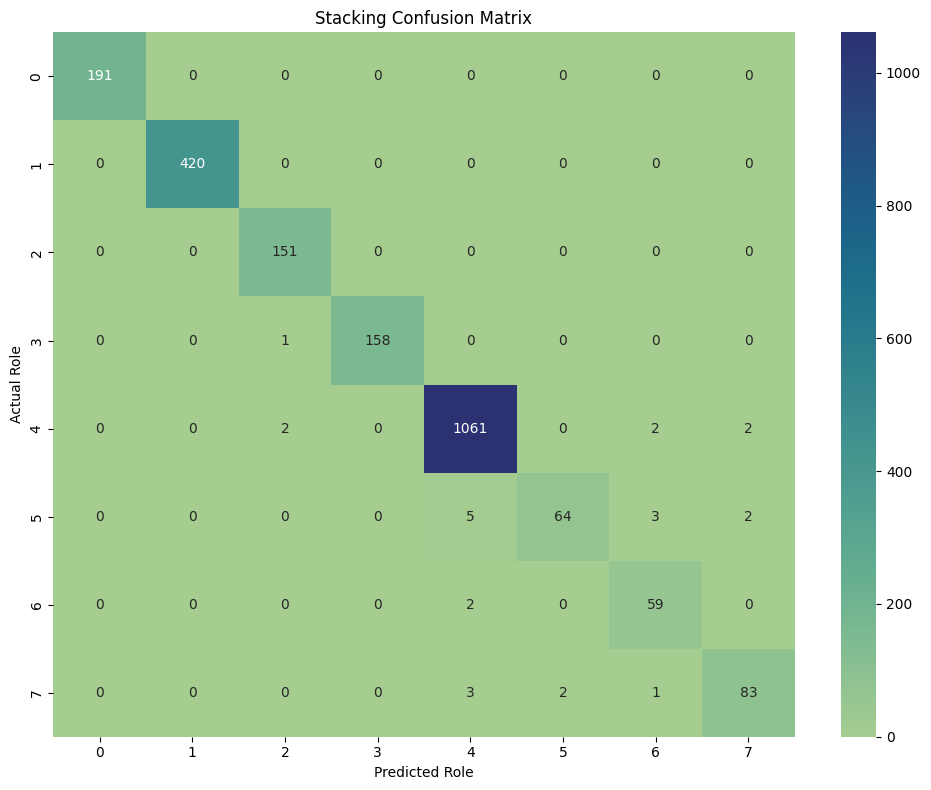

In [ ]:
# Confusion matrix
cm_stack = confusion_matrix(y_test, y_pred_stack)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='crest',
            xticklabels=stacking.classes_, yticklabels=stacking.classes_)
plt.title('Stacking Confusion Matrix')
plt.xlabel('Predicted Role')
plt.ylabel('Actual Role')
plt.tight_layout()
plt.show()


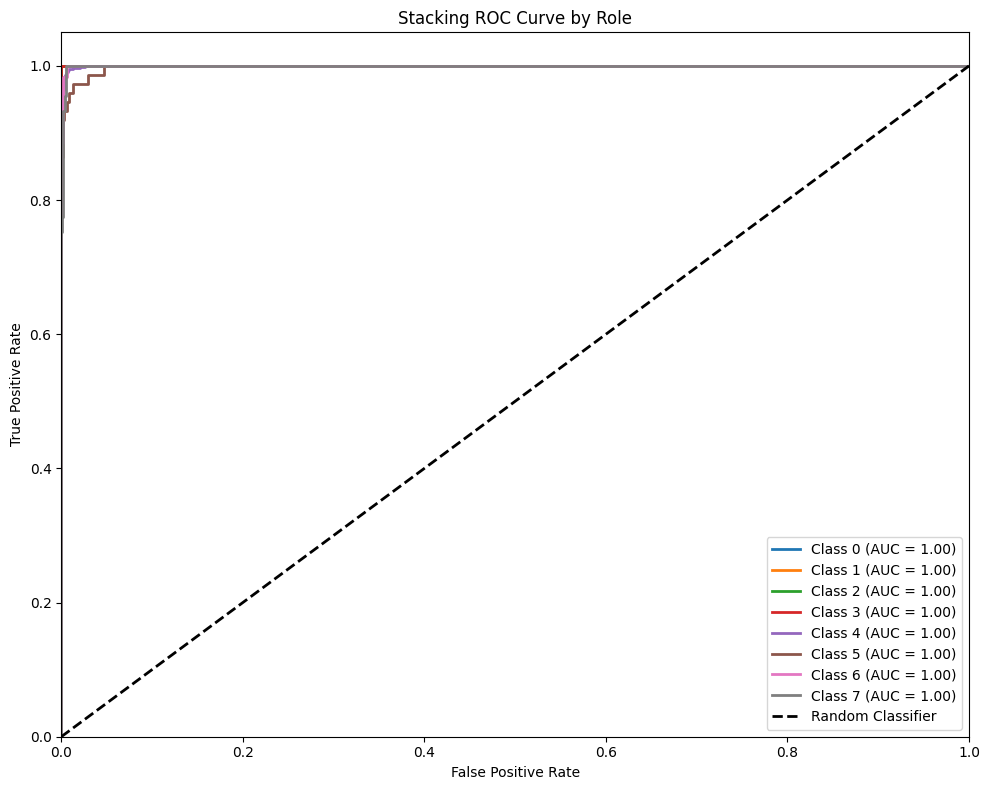

In [ ]:
# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=stacking.classes_)
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba_stack[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {stacking.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacking ROC Curve by Role')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


DT Accuracy: 96.93%
RF Accuracy: 97.06%
ADA Accuracy: 73.55%

Stacking Accuracy: 98.87%


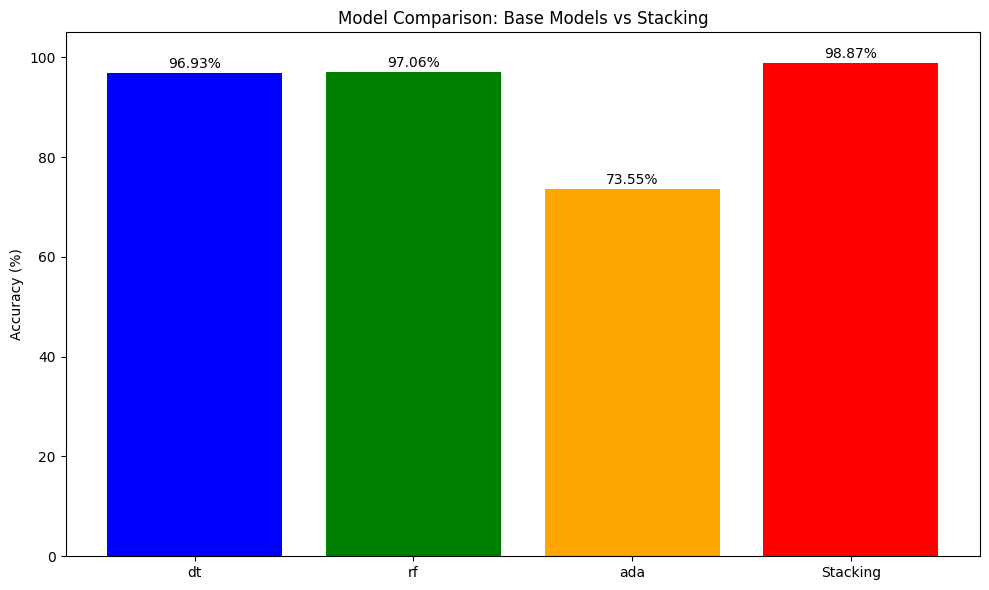

In [ ]:
# Train individual base models and compare
results = {}

for name, model in base_models:
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name.upper()} Accuracy: {acc * 100:.2f}%")

results['Stacking'] = stack_accuracy
print(f"\nStacking Accuracy: {stack_accuracy * 100:.2f}%")

# Plot comparison
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), [v * 100 for v in results.values()], color=['blue', 'green', 'orange', 'red'])
plt.ylabel('Accuracy (%)')
plt.title('Model Comparison: Base Models vs Stacking')
plt.ylim([0, 105])
for i, (k, v) in enumerate(results.items()):
    plt.text(i, v * 100 + 1, f'{v * 100:.2f}%', ha='center')
plt.tight_layout()
plt.show()


In [ ]:
# Predict role for the first player in test set
y_pred_stack_0 = stacking.predict(X_test_scaled[0].reshape(1, -1))
print(f"Predicted role (encoded) for player 0: {y_pred_stack_0[0]}")

# Predict for the second player
y_pred_stack_1 = stacking.predict(X_test_scaled[1].reshape(1, -1))
print(f"Predicted role (encoded) for player 1: {y_pred_stack_1[0]}\n")


Predicted role (encoded) for player 0: 4
Predicted role (encoded) for player 1: 1



In [ ]:
# Test first 3 players
role_mapping = {0: 'GK', 1: 'CB', 2: 'FB', 3: 'DM', 4: 'CM', 5: 'AM', 6: 'W', 7: 'ST'}

print("\n" + "="*60)
print("INDIVIDUAL PREDICTION TESTING")
print("="*60)

for idx in range(3):
    print(f"\n--- Player {idx} ---")

    y_pred = stacking.predict(X_test_scaled[idx].reshape(1, -1))[0]
    y_actual = y_test.iloc[idx]
    probs = stacking.predict_proba(X_test_scaled[idx].reshape(1, -1))[0]
    confidence = probs[y_pred]

    is_correct = "✓ CORRECT" if y_pred == y_actual else "✗ INCORRECT"

    print(f"Predicted: {role_mapping[y_pred]} | Actual: {role_mapping[y_actual]} | {is_correct}")
    print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")



INDIVIDUAL PREDICTION TESTING

--- Player 0 ---
Predicted: CM | Actual: CM | ✓ CORRECT
Confidence: 0.9989 (99.89%)

--- Player 1 ---
Predicted: CB | Actual: CB | ✓ CORRECT
Confidence: 0.9987 (99.87%)

--- Player 2 ---
Predicted: FB | Actual: DM | ✗ INCORRECT
Confidence: 0.8203 (82.03%)
